# Data Gathering Step 

Steps Taken: 
1. Download sample application emails from gmail account as an eml(email) object
2. Convert eml object to an array and then convert to dataframe to store as csv

In [1]:
import datetime
import json
import eml_parser
import os
import glob
import pandas as pd

# # Note : Converts email objects to csv(not needed was used for initial data gathering)
# import numpy as np
# path = os.getcwd()+'/emails'
# emailsArray = [];
# for filename in glob.glob(os.path.join(path, '*.eml')):
#     with open(os.path.join(os.getcwd(), filename), 'rb') as f: # open in readonly mode
#         raw_email = f.read()
#         ep = eml_parser.EmlParser(include_raw_body=True)
#         parsed_eml = ep.decode_email_bytes(raw_email)
#         emailsArray.append(parsed_eml['body'][0]['content'])

# columns = ["Message"]
# df = pd.DataFrame(data=emailsArray, columns=columns)
# df["Status"] = np.nan

In [2]:
# df.iloc[0].Message
# df.to_csv (r'./sampleEmails.csv', index = False, header=True)
# After cleaning up csv

# Building Model

1. Read excel into a dataframe(used excel instead of csv)
2. Then clean up each message, removing all stopwords as well as some other ones(including HTML formatted tags)
3. Use train_test_split to split up the training data and create the Naive Bayes Classifer Model

In [3]:
#Read from Excel sheet with Message, Status and Company
df2 = pd.read_excel('./sampleEmailsWithCompanies.xlsx')
df2

,Message,Status,Company
0,"Hello Akhil,\n\n\n\n Thank you for your intere...",Applied,Tesla
1,"<div>Dear Akhil,</div><div><br></div><div>Than...",Applied,Impossible Foods
2,"Hi Akhil,\n\n\n\nThanks so much for submitting...",Applied,Stripe
3,"<div>Hi Akhil,</div><div><br></div><div>Thank ...",Applied,Scratch
4,"Hi Akhil,\n\nåÊ\n\nThank you for your interest...",Rejected,GRAIL
...,...,...,...
74,Hello - you are apparently my tutor for CS cou...,Junk,None
75,This is an automatically generated e-mail from...,Junk,None
76,"\nThanks for choosing Apple.\nHi Akhil,\n\nIt’...",Junk,None
77,Discover short- and long-term investment oppor...,Junk,None


In [4]:
import string
import nltk
from nltk.corpus import stopwords

def showOnlyKeyWords(mess):
    # Remove all punctuation from the messages section
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    nopunc.split()
    # Remove stop words including some custom ones like hello and Akhil
    stopwords = nltk.corpus.stopwords.words('english')
    newStopWords = ['hello','akhil', 'thank', 'div', 'br', 'thanks', 'hi']
    stopwords.extend(newStopWords)
    clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords]
    return clean_mess

In [5]:
df2['Message'].head(5).apply(showOnlyKeyWords)

0    [interest, joining, team, Tesla, We‰Ûªve, rece...
1    [divDear, AkhildivdivbrdivdivThanks, applying,...
2    [much, submitting, application, Backend, API, ...
3    [divHi, AkhildivdivbrdivdivThank, applying, ro...
4    [åÊ, interest, joining, GRAIL, sharing, vision...
Name: Message, dtype: object

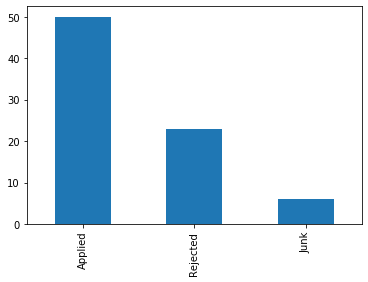

In [6]:
df2.head()
df2['Status'].value_counts().plot(kind="bar")
#Unfortunately at this time I only have about 100 data set of applied, rejected and non application mail(couldnt import more because a lot had sensitive data)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [8]:
X = df2['Message']
y = df2['Status']
comp = df2['Company']
Xcomp = df2['Message']

cv = CountVectorizer()
X = cv.fit_transform(X)
Xcomp = cv.fit_transform(Xcomp)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
# print(type(X))


XComp_train, XComp_test, y_compTrain, y_compTest = train_test_split(Xcomp, comp,test_size=0.2)

nb = MultinomialNB()
nbComp = MultinomialNB()
nb.fit(X_train,y_train)
nbComp.fit(XComp_train, y_compTrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Google API(Gmail) Integration

Using Google's API Library and following their documentation, we start the OAuth 2 process that is required. 

In order to get this app working you will need to enable your account to be able to use Gmail API and download and save the generated credentials json as credentials.json. In addition, if running from a local server will need to add your port in this code as well as on Google API's dashboard(ie : add "localhost:8080/" to redirect URI)

Reccomend using Chrome, and on first run will cause you to sign in to gmail using your browser. After the token.json file has been generated in your directory, the token will autorefresh so no need to keep signing in. 

The rest of the code will handle reading your emails and running it thru the model to predict if the email message indicates if you have been rejected, or just applying or just a random email(this specific one needs more sample data)

In [12]:
from __future__ import print_function

import os
import json
import time
import glob
import pickle
import random
import pandas as pd
import base64
import re
import unpaddedbase64
from pandas import Series, DataFrame

import os.path

# these are just for authenticating
import google.oauth2.credentials
from google_auth_oauthlib.flow import Flow
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials


# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
#         Define port(will have to match redirect URI for local instance)
        creds = flow.run_local_server(port=8080)
    # Save the credentials for the next run
    with open('token.json', 'w') as token:
        token.write(creds.to_json())
service = build('gmail', 'v1', credentials=creds)
results = service.users().messages().list(userId='me').execute()
messageIds = results['messages']
listOfIds = [];
listOfMessages = []
senderOfMessages = [];
for messageId in messageIds:
    listOfIds.append(messageId['id'])
    
for idMail in listOfIds:
    emails = service.users().messages().get(userId='me', id=idMail, format="full").execute()
    senderOfMessages.append(emails['payload']['headers'][-3]['value'])
    data = emails['payload']['parts'][0]['body']['data']
    encodedData = unpaddedbase64.decode_base64(data)
    s = encodedData.decode('UTF-8')
    listOfMessages.append(s)
        
# print(listOfMessages)

statusResult = nb.predict(cv.transform(listOfMessages))


# In the sample the sender has a lot of my email(because email was forwarded so header containers sender not original sender) 

finalDf = pd.DataFrame({'status':statusResult, 'sender':senderOfMessages, 'message':listOfMessages})
finalDf


# If you want to save the results, unccoment the code below


# finalDf.to_csv(r'./jobResults.csv', index = False, header=True)

As You Can see some of the predicitions still need to be worked on as more data is used we can increase the accuracy. However this code will read email messages from your gmail and create a viewable dataframe to see which companies you were rejected from, applied to. As more data is ingested we will be able to increase accuracy as well as identify who Accepted your application as well.